Import kaggle json file

In [5]:
from google.colab import files
files.upload()


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"kolliparaniranjan","key":"5abb70d1310013680bfbd0eedd83e89f"}'}

kaggle dependcies

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


loading malaraia dataset from kaggle

In [7]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria


Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown


unzip the malaria dataset

In [8]:
!unzip cell-images-for-detecting-malaria.zip


Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_i

splitting the data set for training and testing

In [9]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Function to load and preprocess images
def load_data(data_dir, img_size=128):
    images, labels = [], []
    for label, folder in enumerate(['Parasitized', 'Uninfected']):
        folder_path = os.path.join(data_dir, folder)
        for img_file in os.listdir(folder_path):
            try:
                img_path = os.path.join(folder_path, img_file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (img_size, img_size))  # Resize images to 128x128
                images.append(img)
                labels.append(label)
            except:
                pass  # Skip any unreadable images
    return np.array(images), np.array(labels)

# Load and preprocess the images
X, y = load_data('cell_images', img_size=128)
X = X / 255.0  # Normalize the images
y = to_categorical(y, 2)  # One-hot encoding for labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Displayong the few images from the data set

Number of parasitized images: 13780
Number of uninfected images: 13780


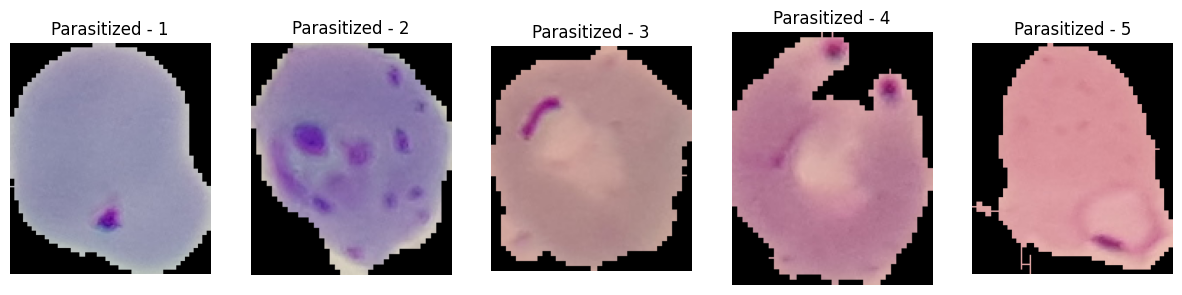

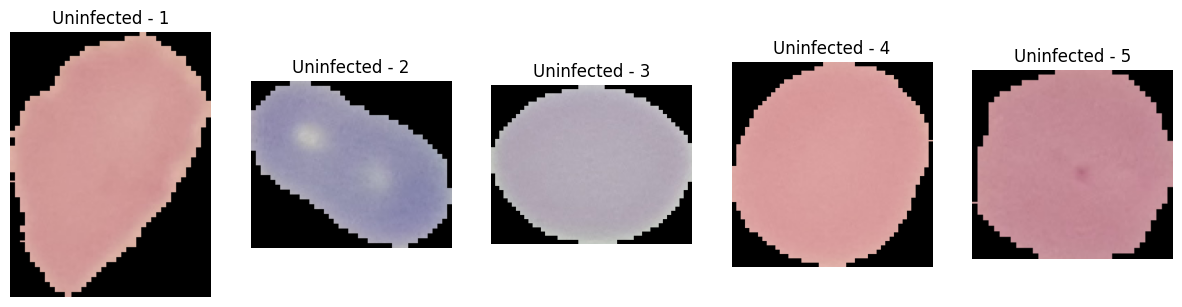

In [10]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Check the number of images in each class
data_dir = 'cell_images'

# List all files in the Parasitized and Uninfected directories
parasitized_dir = os.path.join(data_dir, 'Parasitized')
uninfected_dir = os.path.join(data_dir, 'Uninfected')

parasitized_images = os.listdir(parasitized_dir)
uninfected_images = os.listdir(uninfected_dir)

print(f"Number of parasitized images: {len(parasitized_images)}")
print(f"Number of uninfected images: {len(uninfected_images)}")

# Display a few sample images
def display_images(img_folder, title=""):
    fig, ax = plt.subplots(1, 5, figsize=(15, 10))
    ax = ax.ravel()
    files = os.listdir(img_folder)
    for i in range(5):
        img = mpimg.imread(os.path.join(img_folder, files[i]))
        ax[i].imshow(img)
        ax[i].set_title(f"{title} - {i+1}")
        ax[i].axis('off')
    plt.show()

# Display sample images from both categories
display_images(parasitized_dir, "Parasitized")
display_images(uninfected_dir, "Uninfected")


In [11]:
# Check image shape and size for a few images
img_path = os.path.join(parasitized_dir, parasitized_images[0])
img = mpimg.imread(img_path)
print(f"Image shape: {img.shape}")


Image shape: (160, 139, 3)


In [12]:
print(X_train.shape)
print(X_test.shape)


(22046, 128, 128, 3)
(5512, 128, 128, 3)


Pixel values for the images in data set

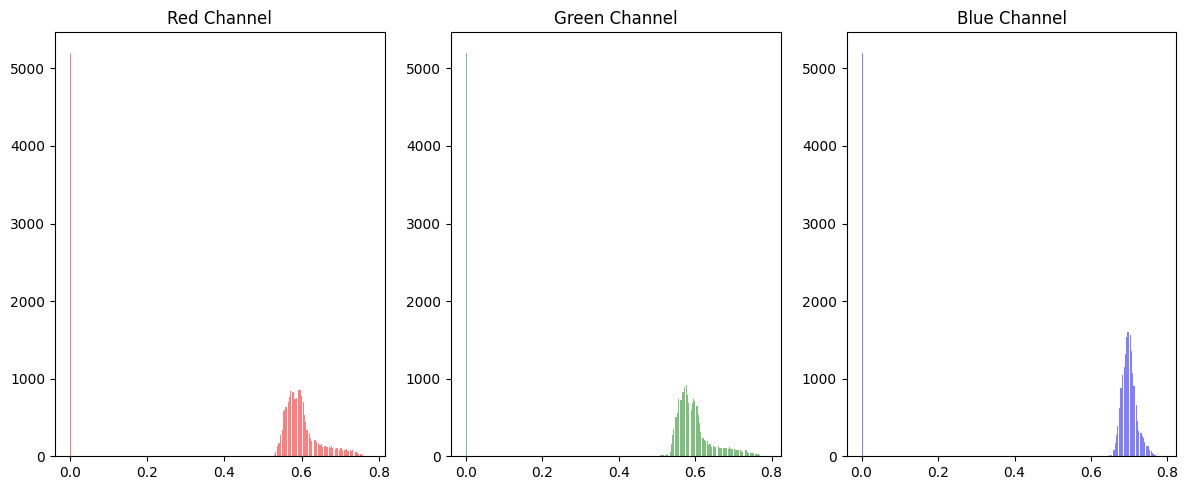

In [13]:
import numpy as np

# Check for pixel value distribution
def show_image_distribution(image_path):
    img = mpimg.imread(image_path)
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]

    # Plot histograms for the RGB channels
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.hist(r.ravel(), bins=256, color='red', alpha=0.5)
    plt.title("Red Channel")
    plt.subplot(1, 3, 2)
    plt.hist(g.ravel(), bins=256, color='green', alpha=0.5)
    plt.title("Green Channel")
    plt.subplot(1, 3, 3)
    plt.hist(b.ravel(), bins=256, color='blue', alpha=0.5)
    plt.title("Blue Channel")
    plt.tight_layout()
    plt.show()

# Show pixel value distribution for a sample image
show_image_distribution(os.path.join(parasitized_dir, parasitized_images[0]))


loading the model(deep cnn)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation

# Build a deeper CNN
model = Sequential()

# 1st Convolutional Block
model.add(Conv2D(32, (3,3), padding='same', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# 2nd Convolutional Block
model.add(Conv2D(64, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# 3rd Convolutional Block
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# 4th Convolutional Block
model.add(Conv2D(256, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,16

 Total params: 1,242,402 (4.74 MB)

 Trainable params: 1,240,482 (4.73 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Model will be trained with augmented data and validated on non-augmented data

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,        # randomly rotate images by 20 degrees
    width_shift_range=0.1,    # shift images horizontally by 10%
    height_shift_range=0.1,   # shift images vertically by 10%
    zoom_range=0.2,           # zoom in up to 20%
    shear_range=0.1,          # shear by 10%
    horizontal_flip=True,     # randomly flip images horizontally
    fill_mode='nearest'       # fill empty pixels after augmentation
)

# For validation, we don't augment - just rescale
valid_datagen = ImageDataGenerator()


This setup ensures efficient handling of the data and will allow the model to train on augmented data while validating on the unaltered test data.

In [16]:
# Create generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
valid_generator = valid_datagen.flow(X_test, y_test, batch_size=32)


trainig the model

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 76s 111ms/step - accuracy: 0.9640 - loss: 0.1079 - val_accuracy: 0.9639 - val_loss: 0.1100 - learning_rate: 5.0000e-04
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 77s 111ms/step - accuracy: 0.9646 - loss: 0.1066 - val_accuracy: 0.9653 - val_loss: 0.1065 - learning_rate: 5.0000e-04
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 76s 111ms/step - accuracy: 0.9640 - loss: 0.1057 - val_accuracy: 0.9690 - val_loss: 0.0992 - learning_rate: 5.0000e-04
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 77s 111ms/step - accuracy: 0.9649 - loss: 0.1025 - val_accuracy: 0.9693 - val_loss: 0.0940 - learning_rate: 5.0000e-04
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 76s 111ms/step - accuracy: 0.9646 - loss: 0.1058 - val_accuracy: 0.9679 - val_loss: 0.1055 - learning_rate: 5.0000e-04
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 76s 111ms/step - accuracy: 0.9642 - loss: 0.1068 - val_accuracy: 0.9712 - val_loss: 0.0947 - learning_rate: 5.0000e-04
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 109

plotting the accuracy and loss on the testing and training data

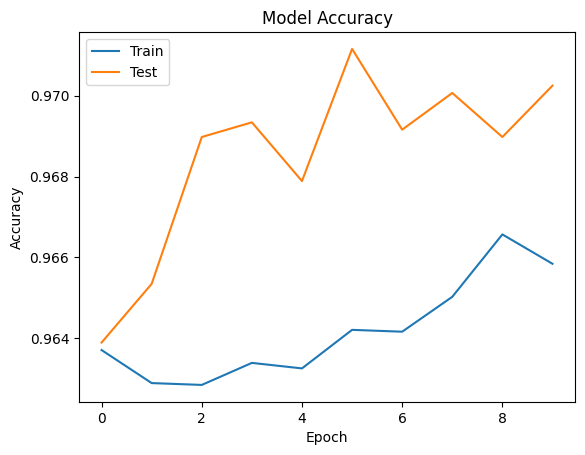

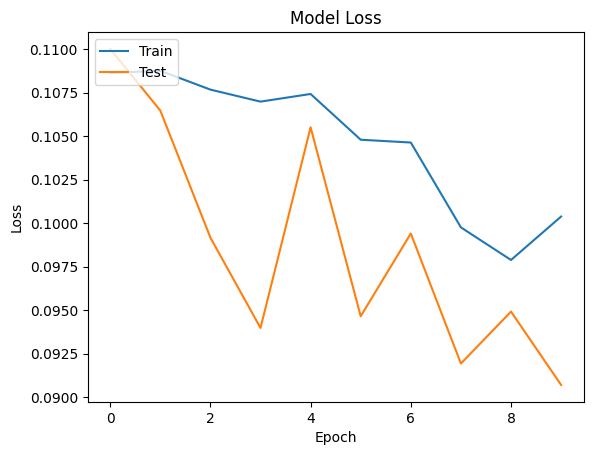

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


testing accuracy and loss

In [22]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9703 - loss: 0.0936
Test Accuracy: 97.02%
Test Loss: 0.0907


Confusion matrix on testing data

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


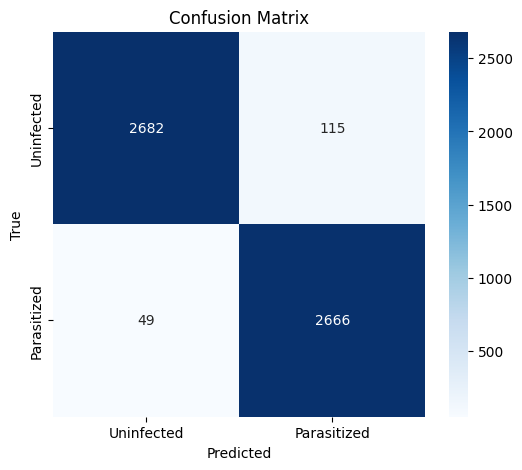

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true is the true labels and y_pred is the predicted labels
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot encoded to label
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded to label

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Confusion matrix,F1 Score, Recall ,Accuracy, Precision,Auc Score(Training data)

689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


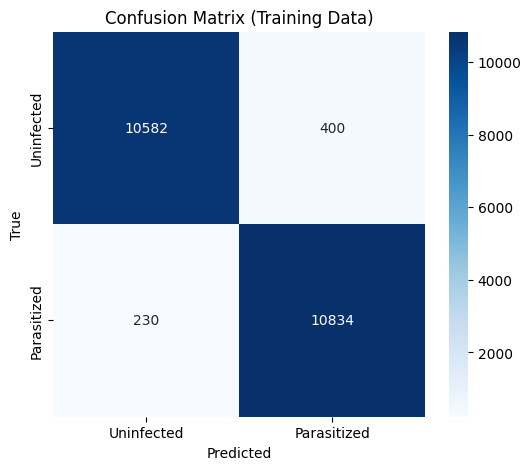

F1 Score (Training Data): 0.9714208682933029
Recall (Training Data): 0.9714233874625783
Accuracy (Training Data): 0.9714233874625783
Precision (Training Data): 0.9715339154962354
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


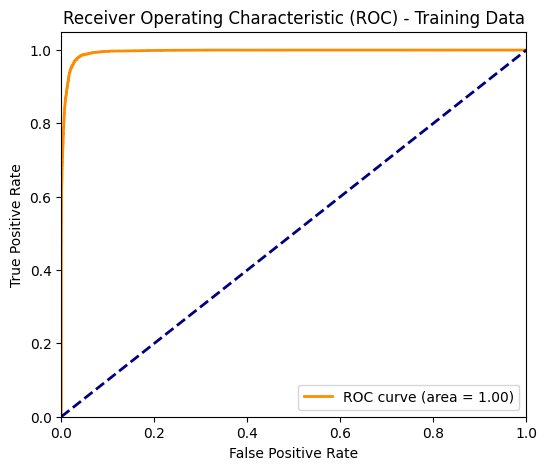

AUC (Training Data): 0.9953342520127263


In [38]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, accuracy_score, precision_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the full training data
y_pred_train = model.predict(X_train)
y_pred_train = np.argmax(y_pred_train, axis=1)  # Convert one-hot encoded to label
y_true_train = np.argmax(y_train, axis=1)  # Convert one-hot encoded to label

# 1. Confusion Matrix
cm = confusion_matrix(y_true_train, y_pred_train)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Training Data)')
plt.show()

# 2. F1 Score
f1 = f1_score(y_true_train, y_pred_train, average='weighted')  # 'weighted' accounts for label imbalance
print(f"F1 Score (Training Data): {f1}")

# 3. Recall
recall = recall_score(y_true_train, y_pred_train, average='weighted')
print(f"Recall (Training Data): {recall}")

# 4. Accuracy
accuracy = accuracy_score(y_true_train, y_pred_train)
print(f"Accuracy (Training Data): {accuracy}")

# 5. Precision
precision = precision_score(y_true_train, y_pred_train, average='weighted')
print(f"Precision (Training Data): {precision}")

# 6. ROC Curve & AUC
lb = LabelBinarizer()
y_true_train_bin = lb.fit_transform(y_true_train)
y_pred_train_bin = lb.transform(y_pred_train)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true_train_bin, model.predict(X_train)[:,1])  # Probability for 'Parasitized'
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Training Data')
plt.legend(loc="lower right")
plt.show()

print(f"AUC (Training Data): {roc_auc}")


Confusion matrix,F1 Score, Recall ,Accuracy, Precision,Auc Score(Testing data)

173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


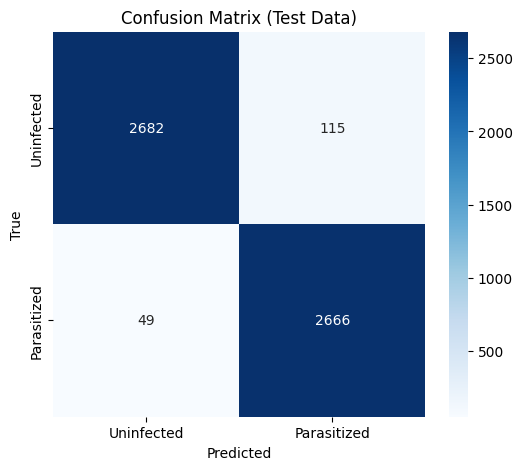

F1 Score (Test Data): 0.9702477685483032
Recall (Test Data): 0.9702467343976778
Accuracy (Test Data): 0.9702467343976778
Precision (Test Data): 0.970527041449565
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


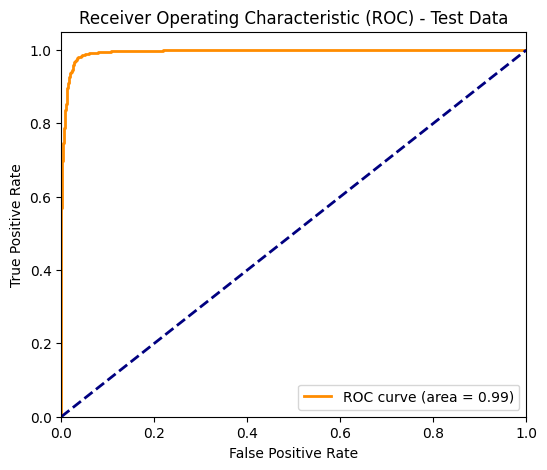

AUC (Test Data): 0.9947414060447558


In [37]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, accuracy_score, precision_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the test data
y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=1)  # Convert one-hot encoded to label
y_true_test = np.argmax(y_test, axis=1)  # Convert one-hot encoded to label

# 1. Confusion Matrix
cm = confusion_matrix(y_true_test, y_pred_test)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Data)')
plt.show()

# 2. F1 Score
f1 = f1_score(y_true_test, y_pred_test, average='weighted')  # 'weighted' accounts for label imbalance
print(f"F1 Score (Test Data): {f1}")

# 3. Recall
recall = recall_score(y_true_test, y_pred_test, average='weighted')
print(f"Recall (Test Data): {recall}")

# 4. Accuracy
accuracy = accuracy_score(y_true_test, y_pred_test)
print(f"Accuracy (Test Data): {accuracy}")

# 5. Precision
precision = precision_score(y_true_test, y_pred_test, average='weighted')
print(f"Precision (Test Data): {precision}")

# 6. ROC Curve & AUC
lb = LabelBinarizer()
y_true_test_bin = lb.fit_transform(y_true_test)
y_pred_test_bin = lb.transform(y_pred_test)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true_test_bin, model.predict(X_test)[:,1])  # Probability for 'Parasitized'
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Test Data')
plt.legend(loc="lower right")
plt.show()

print(f"AUC (Test Data): {roc_auc}")


In [31]:
# Save the model
model.save('malaria_.h5')  # Replace with your desired file name


Precision-Recall curve for Training and Testing Data

689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


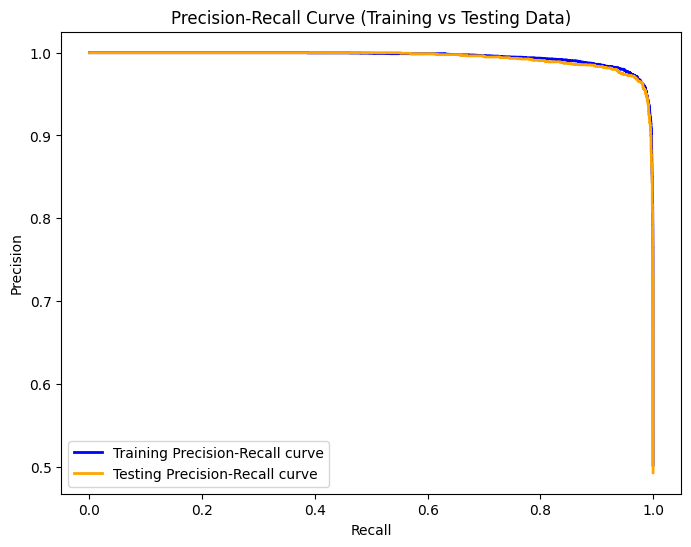

Training Data Precision-Recall AUC: 0.9951
Testing Data Precision-Recall AUC: 0.9943


In [40]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Binarize labels for training and testing
lb = LabelBinarizer()
y_true_train_bin = lb.fit_transform(y_true_train)
y_true_test_bin = lb.transform(y_true_test)

# Get prediction probabilities for both training and testing data
y_pred_train_prob = model.predict(X_train)[:, 1]  # Probability for class 1 (Parasitized)
y_pred_test_prob = model.predict(X_test)[:, 1]    # Probability for class 1 (Parasitized)

# Compute Precision-Recall curve for training data
precision_train, recall_train, _ = precision_recall_curve(y_true_train_bin, y_pred_train_prob)

# Compute Precision-Recall curve for testing data
precision_test, recall_test, _ = precision_recall_curve(y_true_test_bin, y_pred_test_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, color='blue', lw=2, label=f'Training Precision-Recall curve')
plt.plot(recall_test, precision_test, color='orange', lw=2, label=f'Testing Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Training vs Testing Data)')
plt.legend(loc="lower left")
plt.show()

# Optionally, you can print the scores (AUC for Precision-Recall curve)
from sklearn.metrics import average_precision_score

train_pr_auc = average_precision_score(y_true_train_bin, y_pred_train_prob)
test_pr_auc = average_precision_score(y_true_test_bin, y_pred_test_prob)

print(f"Training Data Precision-Recall AUC: {train_pr_auc:.4f}")
print(f"Testing Data Precision-Recall AUC: {test_pr_auc:.4f}")


Matthews Correlation Coefficient (Training and Testing)

In [42]:
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Binarize labels for training and testing
lb = LabelBinarizer()
y_true_train_bin = lb.fit_transform(y_true_train)
y_true_test_bin = lb.transform(y_true_test)

# Calculate MCC for training data
mcc_train = matthews_corrcoef(y_true_train_bin, y_pred_train)
print(f"Matthews Correlation Coefficient (Training Data): {mcc_train}")

# Calculate MCC for testing data
mcc_test = matthews_corrcoef(y_true_test_bin, y_pred_test)
print(f"Matthews Correlation Coefficient (Testing Data): {mcc_test}")


Matthews Correlation Coefficient (Training Data): 0.942954867726217
Matthews Correlation Coefficient (Testing Data): 0.9407712275332304


In [43]:
from sklearn.metrics import log_loss
logloss = log_loss(y_true_train_bin, model.predict(X_train))
print(f"Log Loss (Training Data): {logloss}")


689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Log Loss (Training Data): 0.08448946081182586


classification report (training data,Testing data)

In [47]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

# Generate classification report for training data
print("Classification Report (Training Data):")
print(classification_report(y_true_train, y_pred_train, target_names=['Uninfected', 'Parasitized']))

# Generate classification report for testing data
print("Classification Report (Testing Data):")
print(classification_report(y_true_test, y_pred_test, target_names=['Uninfected', 'Parasitized']))


Classification Report (Training Data):
              precision    recall  f1-score   support

  Uninfected       0.98      0.96      0.97     10982
 Parasitized       0.96      0.98      0.97     11064

    accuracy                           0.97     22046
   macro avg       0.97      0.97      0.97     22046
weighted avg       0.97      0.97      0.97     22046

Classification Report (Testing Data):
              precision    recall  f1-score   support

  Uninfected       0.98      0.96      0.97      2797
 Parasitized       0.96      0.98      0.97      2715

    accuracy                           0.97      5512
   macro avg       0.97      0.97      0.97      5512
weighted avg       0.97      0.97      0.97      5512



model history

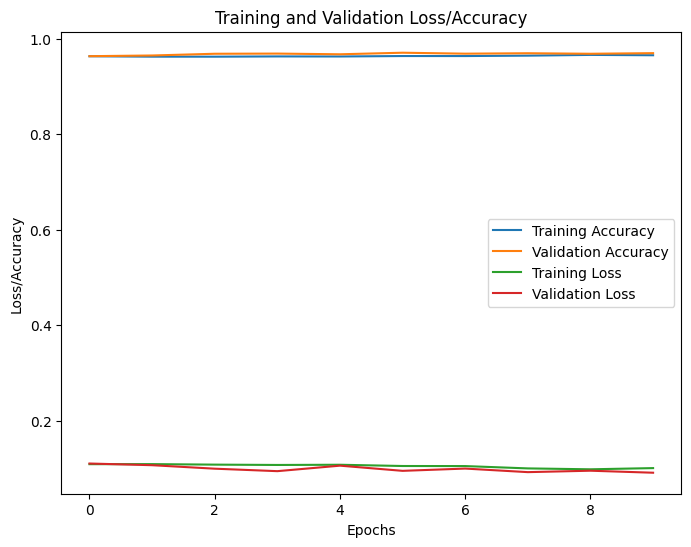

In [45]:
# Assuming you have history from model.fit()
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss/Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()


In [23]:
# Making predictions
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Display predictions for the first few test samples
print(predicted_labels[:10])  # Display the first 10 predicted labels


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
[0 0 1 1 1 1 0 0 0 0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicted Label: Uninfected
Prediction Probabilities: [[0.00871428 0.99128574]]
Confidence: 99.13%


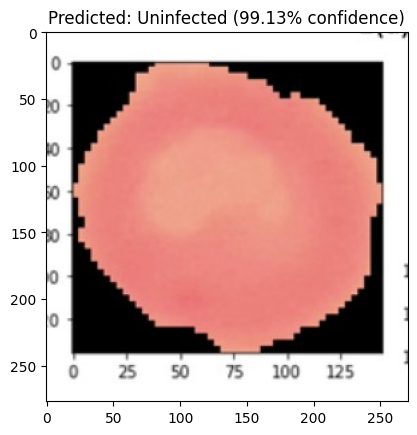

In [36]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model  # Import the load_model function

# Load the saved model (make sure the model path is correct)
model = load_model('/content/malaria_.h5')  # Replace with your model's file path

# Function to preprocess the image
def preprocess_image(img_path, img_size=128):
    img = image.load_img(img_path, target_size=(img_size, img_size))  # Load and resize image
    img_array = image.img_to_array(img)  # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image
    return img_array

# Function to predict the image
def predict_image(img_path):
    # Preprocess the image
    processed_img = preprocess_image(img_path)

    # Make the prediction
    prediction = model.predict(processed_img)

    # Get the predicted class index and the corresponding probability
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_prob = np.max(prediction, axis=1)[0]

    # Map the class index to label
    class_names = ['Infected', 'Uninfected']  # Adjust based on your classes
    predicted_label = class_names[predicted_class]

    # Display prediction result
    print(f"Predicted Label: {predicted_label}")
    print(f"Prediction Probabilities: {prediction}")
    print(f"Confidence: {predicted_prob * 100:.2f}%")  # Confidence as a percentage

    # Optionally display the image
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label} ({predicted_prob * 100:.2f}% confidence)")
    plt.show()

# Example usage:
img_path = '/content/uninfected.jpg'  # Replace with your image file path
predict_image(img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Label: Uninfected
Prediction Probabilities: [[0.00871428 0.99128574]]
Confidence: 99.13%


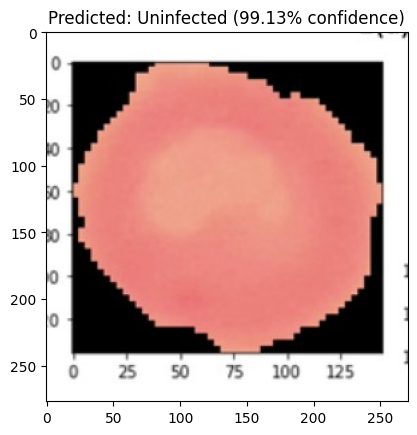

In [35]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Function to preprocess the image
def preprocess_image(img_path, img_size=128):
    img = image.load_img(img_path, target_size=(img_size, img_size))  # Load and resize image
    img_array = image.img_to_array(img)  # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image
    return img_array

# Function to predict the image
def predict_image(img_path):
    # Preprocess the image
    processed_img = preprocess_image(img_path)

    # Make the prediction
    prediction = model.predict(processed_img)

    # Get the predicted class index and the corresponding probability
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_prob = np.max(prediction, axis=1)[0]

    # Map the class index to label
    class_names = ['Infected', 'Uninfected']  # Adjust based on your classes
    predicted_label = class_names[predicted_class]

    # Display prediction result
    print(f"Predicted Label: {predicted_label}")
    print(f"Prediction Probabilities: {prediction}")
    print(f"Confidence: {predicted_prob * 100:.2f}%")  # Confidence as a percentage

    # Optionally display the image
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label} ({predicted_prob * 100:.2f}% confidence)")
    plt.show()

# Example usage:
img_path = '/content/uninfected.jpg'  # Replace with your image file path
predict_image(img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Label: Infected
Prediction Probabilities: [[9.9997377e-01 2.6241245e-05]]
Confidence: 100.00%


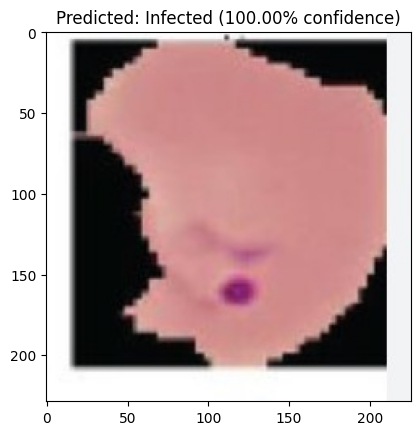

In [34]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Function to preprocess the image
def preprocess_image(img_path, img_size=128):
    img = image.load_img(img_path, target_size=(img_size, img_size))  # Load and resize image
    img_array = image.img_to_array(img)  # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image
    return img_array

# Function to predict the image
def predict_image(img_path):
    # Preprocess the image
    processed_img = preprocess_image(img_path)

    # Make the prediction
    prediction = model.predict(processed_img)

    # Get the predicted class index and the corresponding probability
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_prob = np.max(prediction, axis=1)[0]

    # Map the class index to label
    class_names = ['Infected', 'Uninfected']  # Adjust based on your classes
    predicted_label = class_names[predicted_class]

    # Display prediction result
    print(f"Predicted Label: {predicted_label}")
    print(f"Prediction Probabilities: {prediction}")
    print(f"Confidence: {predicted_prob * 100:.2f}%")  # Confidence as a percentage

    # Optionally display the image
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label} ({predicted_prob * 100:.2f}% confidence)")
    plt.show()

# Example usage:
img_path = '/content/Screenshot 2025-04-27 120053.jpg'  # Replace with your image file path
predict_image(img_path)
